<a href="https://colab.research.google.com/github/kimwoonggon/publicservant_AI/blob/master/02_%EC%9E%90%EC%97%B0%EC%96%B4%EC%B2%98%EB%A6%AC_News_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 뉴스 카테고리 분류하기  
본 튜토리얼에서는 사전학습된 임베딩을 활용하여 뉴스의 카테고리를 분류하는 실습을 하고자 합니다.  
https://www.kaggle.com/rmisra/news-category-dataset 의 자료를 참조하였습니다.  
  
![imgur](https://i.imgur.com/bp9eNMS.jpg)  
  
  헤드라인과 기사요약 칼럼을 활용해서, 뉴스 category를 맞추는 문제입니다.  
  category는 40종으로 이루어져 있어서 생각보다 어려운 문제입니다.

In [0]:
import numpy as np
import pandas as pd
from keras import backend as K
from keras.layers import Embedding, Dense, Input, LSTM, Bidirectional, Activation, Conv1D, GRU, TimeDistributed, Dropout
from keras.models import Model

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import os
from tqdm import tqdm

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
import warnings
import tensorflow as tf
warnings.filterwarnings(action='ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.logging.set_verbosity(tf.logging.ERROR)

In [0]:
import os
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
os.listdir('gdrive/My Drive/Colab Notebooks/education')

['GoogleNews-vectors-negative300.bin.gz',
 'sms-spam-collection-dataset.zip',
 'spam.csv',
 'News_Category_Dataset_v2.json']

In [0]:
path = 'gdrive/My Drive/Colab Notebooks/education'

뉴스 데이터를 불러옵니다.

In [0]:
data = pd.read_json(os.path.join(path,'News_Category_Dataset_v2.json'), lines=True)

In [0]:
data.head(5)

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


데이터는 200,853개의 뉴스와, 7개의 칼럼으로 이루어져 있습니다.

In [0]:
data.shape

(200853, 7)

In [0]:
data['category'].unique()

array(['CRIME', 'ENTERTAINMENT', 'WORLD NEWS', 'IMPACT', 'POLITICS',
       'WEIRD NEWS', 'BLACK VOICES', 'WOMEN', 'COMEDY', 'QUEER VOICES',
       'SPORTS', 'BUSINESS', 'TRAVEL', 'MEDIA', 'TECH', 'RELIGION',
       'SCIENCE', 'LATINO VOICES', 'EDUCATION', 'COLLEGE', 'PARENTS',
       'ARTS & CULTURE', 'STYLE', 'GREEN', 'TASTE', 'HEALTHY LIVING',
       'THE WORLDPOST', 'GOOD NEWS', 'WORLDPOST', 'FIFTY', 'ARTS',
       'WELLNESS', 'PARENTING', 'HOME & LIVING', 'STYLE & BEAUTY',
       'DIVORCE', 'WEDDINGS', 'FOOD & DRINK', 'MONEY', 'ENVIRONMENT',
       'CULTURE & ARTS'], dtype=object)

우리가 예측해야 하는 것은 category인데요, 잘 보시면 WORLDPOST와 THE WORLDPOST가 실제로는 같은 카테고리인데 나뉘어져 있음을 알 수 있습니다.  
pandas의 map 함수를 활용하여 WORLDPOST와 THE WORLDPOST를 합쳐줍니다.

In [0]:
data['category'] = data['category'].map(lambda x: "WORLDPOST" if x == 'THE WORLDPOST' else x)

In [0]:
data['category'].unique()

array(['CRIME', 'ENTERTAINMENT', 'WORLD NEWS', 'IMPACT', 'POLITICS',
       'WEIRD NEWS', 'BLACK VOICES', 'WOMEN', 'COMEDY', 'QUEER VOICES',
       'SPORTS', 'BUSINESS', 'TRAVEL', 'MEDIA', 'TECH', 'RELIGION',
       'SCIENCE', 'LATINO VOICES', 'EDUCATION', 'COLLEGE', 'PARENTS',
       'ARTS & CULTURE', 'STYLE', 'GREEN', 'TASTE', 'HEALTHY LIVING',
       'WORLDPOST', 'GOOD NEWS', 'FIFTY', 'ARTS', 'WELLNESS', 'PARENTING',
       'HOME & LIVING', 'STYLE & BEAUTY', 'DIVORCE', 'WEDDINGS',
       'FOOD & DRINK', 'MONEY', 'ENVIRONMENT', 'CULTURE & ARTS'],
      dtype=object)

headline 데이터와 short_description 데이터를 합쳐줍니다.

In [0]:
data['text'] = data['headline'] + " " + data['short_description']

IMDB 데이터와 다르게 자연어 처리 모듈인 NLTK를 활용하여 단어 토큰화를 진행하도록 하겠습니다.

In [0]:
#NLTK TOKENIZER 사용하기
import nltk
nltk.download("book", quiet=True)
from nltk.book import *

*** Introductory Examples for the NLTK Book ***
Loading text1, ..., text9 and sent1, ..., sent9
Type the name of the text or sentence to view it.
Type: 'texts()' or 'sents()' to list the materials.
text1: Moby Dick by Herman Melville 1851
text2: Sense and Sensibility by Jane Austen 1811
text3: The Book of Genesis
text4: Inaugural Address Corpus
text5: Chat Corpus
text6: Monty Python and the Holy Grail
text7: Wall Street Journal
text8: Personals Corpus
text9: The Man Who Was Thursday by G . K . Chesterton 1908


정규식을 사용해서 문장에서 숫자와 알파벳이 아닌 단어들은 제외해주겠습니다.  
그리고 문장을 단어로 구성된 리스트로 바꿔 주도록 하겠습니다.

In [0]:
from nltk.tokenize import RegexpTokenizer
retokenize = RegexpTokenizer("[\w]+")

In [0]:
text_list = []
for sentence in data['text'].tolist():
  text_list.append(retokenize.tokenize(sentence))

문장이 단어들로 분해되었음을 알 수 있습니다.

In [0]:
print(text_list[:20])

[['There', 'Were', '2', 'Mass', 'Shootings', 'In', 'Texas', 'Last', 'Week', 'But', 'Only', '1', 'On', 'TV', 'She', 'left', 'her', 'husband', 'He', 'killed', 'their', 'children', 'Just', 'another', 'day', 'in', 'America'], ['Will', 'Smith', 'Joins', 'Diplo', 'And', 'Nicky', 'Jam', 'For', 'The', '2018', 'World', 'Cup', 's', 'Official', 'Song', 'Of', 'course', 'it', 'has', 'a', 'song'], ['Hugh', 'Grant', 'Marries', 'For', 'The', 'First', 'Time', 'At', 'Age', '57', 'The', 'actor', 'and', 'his', 'longtime', 'girlfriend', 'Anna', 'Eberstein', 'tied', 'the', 'knot', 'in', 'a', 'civil', 'ceremony'], ['Jim', 'Carrey', 'Blasts', 'Castrato', 'Adam', 'Schiff', 'And', 'Democrats', 'In', 'New', 'Artwork', 'The', 'actor', 'gives', 'Dems', 'an', 'ass', 'kicking', 'for', 'not', 'fighting', 'hard', 'enough', 'against', 'Donald', 'Trump'], ['Julianna', 'Margulies', 'Uses', 'Donald', 'Trump', 'Poop', 'Bags', 'To', 'Pick', 'Up', 'After', 'Her', 'Dog', 'The', 'Dietland', 'actress', 'said', 'using', 'the', '

영어 단어에서, 어간을 추출해보도록 하겠습니다.  
예를 들어서 shooting이나 shoot이나 의미는 비슷할 것입니다.  
이러한 변형 형태를 하나로 만들어주는 어간을 nltk를 활용하여 추출하도록 하겠습니다.

In [0]:
# 어간 추출하기
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords


stops = set(stopwords.words('english'))
st = PorterStemmer()

stem_text_list = []
for sentence in tqdm(text_list):
    stem_text_list.append([st.stem(w) for w in sentence if w not in stops])

100%|██████████| 200853/200853 [01:04<00:00, 3110.41it/s]


In [0]:
print(text_list[:20])

[['There', 'Were', '2', 'Mass', 'Shootings', 'In', 'Texas', 'Last', 'Week', 'But', 'Only', '1', 'On', 'TV', 'She', 'left', 'her', 'husband', 'He', 'killed', 'their', 'children', 'Just', 'another', 'day', 'in', 'America'], ['Will', 'Smith', 'Joins', 'Diplo', 'And', 'Nicky', 'Jam', 'For', 'The', '2018', 'World', 'Cup', 's', 'Official', 'Song', 'Of', 'course', 'it', 'has', 'a', 'song'], ['Hugh', 'Grant', 'Marries', 'For', 'The', 'First', 'Time', 'At', 'Age', '57', 'The', 'actor', 'and', 'his', 'longtime', 'girlfriend', 'Anna', 'Eberstein', 'tied', 'the', 'knot', 'in', 'a', 'civil', 'ceremony'], ['Jim', 'Carrey', 'Blasts', 'Castrato', 'Adam', 'Schiff', 'And', 'Democrats', 'In', 'New', 'Artwork', 'The', 'actor', 'gives', 'Dems', 'an', 'ass', 'kicking', 'for', 'not', 'fighting', 'hard', 'enough', 'against', 'Donald', 'Trump'], ['Julianna', 'Margulies', 'Uses', 'Donald', 'Trump', 'Poop', 'Bags', 'To', 'Pick', 'Up', 'After', 'Her', 'Dog', 'The', 'Dietland', 'actress', 'said', 'using', 'the', '

위의 단어와 비교해 보면 shootings는 shoot으로, killed는 kill 로, 바뀌었음을 알 수 있습니다.

In [0]:
print(stem_text_list[:20])

[['there', 'were', '2', 'mass', 'shoot', 'In', 'texa', 'last', 'week', 'but', 'onli', '1', 'On', 'TV', 'she', 'left', 'husband', 'He', 'kill', 'children', 'just', 'anoth', 'day', 'america'], ['will', 'smith', 'join', 'diplo', 'and', 'nicki', 'jam', 'for', 'the', '2018', 'world', 'cup', 'offici', 'song', 'Of', 'cours', 'song'], ['hugh', 'grant', 'marri', 'for', 'the', 'first', 'time', 'At', 'age', '57', 'the', 'actor', 'longtim', 'girlfriend', 'anna', 'eberstein', 'tie', 'knot', 'civil', 'ceremoni'], ['jim', 'carrey', 'blast', 'castrato', 'adam', 'schiff', 'and', 'democrat', 'In', 'new', 'artwork', 'the', 'actor', 'give', 'dem', 'ass', 'kick', 'fight', 'hard', 'enough', 'donald', 'trump'], ['julianna', 'marguli', 'use', 'donald', 'trump', 'poop', 'bag', 'To', 'pick', 'Up', 'after', 'her', 'dog', 'the', 'dietland', 'actress', 'said', 'use', 'bag', 'realli', 'cathart', 'therapeut', 'moment'], ['morgan', 'freeman', 'devast', 'that', 'sexual', 'harass', 'claim', 'could', 'undermin', 'legaci

In [0]:
# 단어들에 넘버링 하기
tokenizer = Tokenizer()
tokenizer.fit_on_texts(stem_text_list)
x_train = tokenizer.texts_to_sequences(stem_text_list)

max length : 155
average length : 21.35450304451514


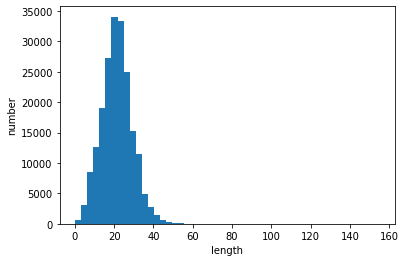

In [0]:
print('max length :',max(len(l) for l in x_train))
print('average length :',sum(map(len, x_train))/len(x_train))
plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length')
plt.ylabel('number')
plt.show()

In [0]:
max_len = 80

In [0]:
x_train = pad_sequences(x_train, maxlen=max_len)
y_train = np.array(data['category'].factorize()[0])

In [0]:
y_train

array([ 0,  1,  1, ..., 10, 10, 10])

gensim 모듈을 활용하여 사전학습된 언어 모델을 불러옵니다.  
glove는 word2vec 이후에 나온 사전학습된 언어 모델입니다.  

In [0]:
import gensim

In [0]:
import os, requests, shutil

glove_dir = './glove'
glove_100k_50d = 'glove.first-100k.6B.50d.txt'
glove_100k_50d_path = os.path.join(glove_dir, glove_100k_50d)

# These are temporary files if we need to download it from the original source (slow)
data_cache = './data/cache'
glove_full_tar = 'glove.6B.zip'
glove_full_50d = 'glove.6B.50d.txt'

#force_download_from_original=False
download_url= 'http://redcatlabs.com/downloads/deep-learning-workshop/notebooks/data/RNN/'+glove_100k_50d
original_url = 'http://nlp.stanford.edu/data/'+glove_full_tar

if not os.path.isfile( glove_100k_50d_path ):
    if not os.path.exists(glove_dir):
        os.makedirs(glove_dir)
    
    # First, try to download a pre-prepared file directly...
    response = requests.get(download_url, stream=True)
    if response.status_code == requests.codes.ok:
        print("Downloading 42Mb pre-prepared GloVE file from RedCatLabs")
        with open(glove_100k_50d_path, 'wb') as out_file:
            shutil.copyfileobj(response.raw, out_file)
    else:
        # But, for some reason, RedCatLabs didn't give us the file directly
        if not os.path.exists(data_cache):
            os.makedirs(data_cache)
        
        if not os.path.isfile( os.path.join(data_cache, glove_full_50d) ):
            zipfilepath = os.path.join(data_cache, glove_full_tar)
            if not os.path.isfile( zipfilepath ):
                print("Downloading 860Mb GloVE file from Stanford")
                response = requests.get(download_url, stream=True)
                with open(zipfilepath, 'wb') as out_file:
                    shutil.copyfileobj(response.raw, out_file)
            if os.path.isfile(zipfilepath):
                print("Unpacking 50d GloVE file from zip")
                import zipfile
                zipfile.ZipFile(zipfilepath, 'r').extract(glove_full_50d, data_cache)

        with open(os.path.join(data_cache, glove_full_50d), 'rt') as in_file:
            with open(glove_100k_50d_path, 'wt') as out_file:
                print("Reducing 50d GloVE file to first 100k words")
                for i, l in enumerate(in_file.readlines()):
                    if i>=100000: break
                    out_file.write(l)
    
        # Get rid of tarfile source (the required text file itself will remain)
        #os.unlink(zipfilepath)
        #os.unlink(os.path.join(data_cache, glove_full_50d))

print("GloVE available locally")

def loadGloveModel(gloveFile):
    print("Loading Glove Model")
    f = open(gloveFile,'r')
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print("Done.",len(model)," words loaded!")
    return model

GloVE available locally


In [0]:
word_embedding = loadGloveModel(glove_100k_50d_path)

Loading Glove Model
Done. 100000  words loaded!


단어 하나 하나가, 50개의 벡터로 임베딩 되었음을 보실 수 있습니다.

In [0]:
word_embedding

{'the': array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
        -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
         2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
         1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
        -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
        -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
         4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
         7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
        -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
         1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01]),
 ',': array([ 0.013441,  0.23682 , -0.16899 ,  0.40951 ,  0.63812 ,  0.47709 ,
        -0.42852 , -0.55641 , -0.364   , -0.23938 ,  0.13001 , -0.063734,
        -0.39575 , -0.48162 ,  0.23291 ,  0.090201, -0.13324 ,  0.078639,
        -0.41634 , -0.15428 ,  0.1

사전 임베딩된 모델에서, 우리가 문장에 있는 데이터만 가지고서 embedding matrix를 만듭니다.  
설명드리자면, 사전 임베딩된 모델은 우리가 문장에 있는 단어뿐만아니라 외부에 있는 단어(wikipedia)같은 곳에 있는 것들로도 학습이 된 것입니다.  
따라서 우리가 훈련에 필요한 단어의 임베딩만 가져오는 작업이 필요합니다.

In [0]:
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, 50))
np.shape(embedding_matrix)

(61085, 50)

In [0]:
def get_vector(word):
    if word in word_embedding:
        return word_embedding[word]
    else:
        return None

for word, i in tokenizer.word_index.items():
    temp = get_vector(word)
    if temp is not None:
        embedding_matrix[i] = temp

**category는** array(['CRIME', 'ENTERTAINMENT', 'WORLD NEWS', 'IMPACT', 'POLITICS',
       'WEIRD NEWS', 'BLACK VOICES', 'WOMEN', 'COMEDY', 'QUEER VOICES',
       'SPORTS', 'BUSINESS', 'TRAVEL', 'MEDIA', 'TECH', 'RELIGION',
       'SCIENCE', 'LATINO VOICES', 'EDUCATION', 'COLLEGE', 'PARENTS',
       'ARTS & CULTURE', 'STYLE', 'GREEN', 'TASTE', 'HEALTHY LIVING',
       'WORLDPOST', 'GOOD NEWS', 'FIFTY', 'ARTS', 'WELLNESS', 'PARENTING',
       'HOME & LIVING', 'STYLE & BEAUTY', 'DIVORCE', 'WEDDINGS',
       'FOOD & DRINK', 'MONEY', 'ENVIRONMENT', 'CULTURE & ARTS']  
        **같은 문자로 이루어져 있습니다. 이 문자들을 숫자들로 변경해줍니다**

In [0]:
data['category'] = data['category'].factorize()[0]

In [0]:
data['category'].unique().shape

(40,)

In [0]:
int_category = data['category'].unique().shape[0]

어텐션 모형을 사용하도록 하겠습니다.  
RNN, LSTM의 단점은, 문장이 길어질수록 훈련 과정에서 gradient가 소실되는 경향이 있습니다. 그래서 모델의 성능을 저하하기도 합니다.  
  
  **어텐션 모형은 LSTM 알고리즘 적용 후, 훈련 과정에서 한번 더 전의 학습 과정을 복습하는 효과를 가지게 됩니다.** 사실 유명한 모형인 BERT 모형도 어텐션 층으로 이루어진 모델을 가지고 있습니다.  
![imgur](https://i.imgur.com/MGgDWxi.jpg)

In [0]:
!pip install keras-self-attention

  Created wheel for keras-self-attention: filename=keras_self_attention-0.42.0-cp36-none-any.whl size=17296 sha256=32ab1fc748a83c5f3bee2064b7d384e61ed557cfaaec72feb0a78233bc5ae715
  Stored in directory: /root/.cache/pip/wheels/7b/05/a0/99c0cf60d383f0494e10eca2b238ea98faca9a1fe03cac2894
Successfully built keras-self-attention


In [0]:
from keras_self_attention import SeqWeightedAttention

이번에는 sparse_categorical_crossentropy를 사용하도록 하겠습니다.  
보통 categorical_crossentropy 같은 경우에는 만약에 라벨이 0,1,2 라면, [1,0,0], [0,1,0], [0,0,1]로 변환하는 작업이 필요합니다.  
sparse_categorical_crossentropy 같은 경우에는 라벨을 변환할 필요 없이 훈련에 라벨을 사용할 수 있습니다.

In [0]:
e = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=max_len, trainable=False)
inputs = Input(shape=(max_len,), dtype='int32')
embedding= e(inputs)
x = Bidirectional(LSTM(50, return_sequences=True))(embedding)
merged = SeqWeightedAttention()(x) #attention layer 추가
merged = Dense(80, activation='relu')(merged)
merged = Dropout(0.25)(merged)

outputs = Dense(int_category, activation='softmax')(merged)

attention_model = Model(inputs=inputs, outputs=outputs)
attention_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])

attention_model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 80)                0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 80, 50)            3054250   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 80, 100)           40400     
_________________________________________________________________
seq_weighted_attention_8 (Se (None, 100)               101       
_________________________________________________________________
dense_13 (Dense)             (None, 80)                8080      
_________________________________________________________________
dropout_13 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 40)                3240

모델의 FLOW를 그림으로 나타내 보도록 하겠습니다.

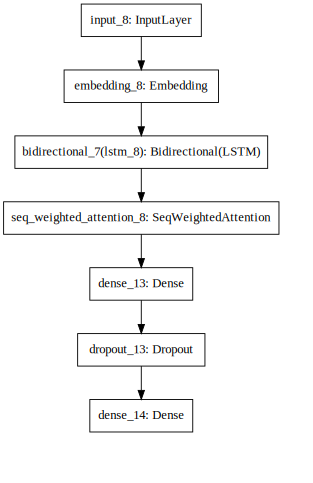

In [0]:
from IPython.display import SVG
from keras.utils import model_to_dot
SVG(model_to_dot(attention_model, dpi=65).create(prog='dot', format='svg'))

In [0]:
history = attention_model.fit(x_train, y_train, batch_size = 2048, validation_split=0.1, shuffle=True, epochs=40)

Train on 180767 samples, validate on 20086 samples
Epoch 1/40
180767/180767 [==============================] - 24s 135us/step - loss: 3.1544 - sparse_categorical_accuracy: 0.2254 - val_loss: 2.8328 - val_sparse_categorical_accuracy: 0.2658
Epoch 2/40
180767/180767 [==============================] - 22s 120us/step - loss: 2.5191 - sparse_categorical_accuracy: 0.3505 - val_loss: 2.2996 - val_sparse_categorical_accuracy: 0.4387
Epoch 3/40
180767/180767 [==============================] - 22s 122us/step - loss: 2.2512 - sparse_categorical_accuracy: 0.4048 - val_loss: 2.0994 - val_sparse_categorical_accuracy: 0.4774
Epoch 4/40
180767/180767 [==============================] - 22s 119us/step - loss: 2.1273 - sparse_categorical_accuracy: 0.4309 - val_loss: 2.0591 - val_sparse_categorical_accuracy: 0.4868
Epoch 5/40
180767/180767 [==============================] - 22s 122us/step - loss: 2.0446 - sparse_categorical_accuracy: 0.4506 - val_loss: 1.8454 - val_sparse_categorical_accuracy: 0.5359
Epoc

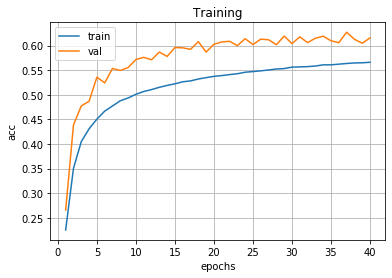

In [0]:
epochs = range(1, len(history.history['sparse_categorical_accuracy']) + 1)
plt.plot(epochs, history.history['sparse_categorical_accuracy'])
plt.plot(epochs, history.history['val_sparse_categorical_accuracy'])
plt.title('Training')
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()